# 1) 1/M orthogonal signals

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# M = num signals to generate
# N = dimension of signals
def generate_orthogonal_signals(M, N):
    signals = np.random.normal(size=(M, N))
    orthogonal_signals = np.zeros((M, N))
    
    for i in range(M):
        orthogonal_signals[i] = signals[i]
        for j in range(i):
            orthogonal_signals[i] -= np.dot(orthogonal_signals[j], signals[i]) / np.dot(orthogonal_signals[j], orthogonal_signals[j]) * orthogonal_signals[j]
        
        # Normalize the signal
        orthogonal_signals[i] /= np.linalg.norm(orthogonal_signals[i])
    
    return orthogonal_signals

def calcPdPfa(data):
    h1s = data[data[:,1] == 1].shape[0]
    h0s = data[data[:,1] == 0].shape[0]

    currh1 = h1s
    currh0 = h0s

    pd = [1]
    pfa = [1]
    for i in data:
        if i[1] == 1:
            currh1 -= 1
        elif i[1] == 0:
            currh0 -= 1
        pd.append(currh1/h1s)
        pfa.append(currh0/h0s)
    pd.append(0)
    pfa.append(0)
    return pd,pfa  


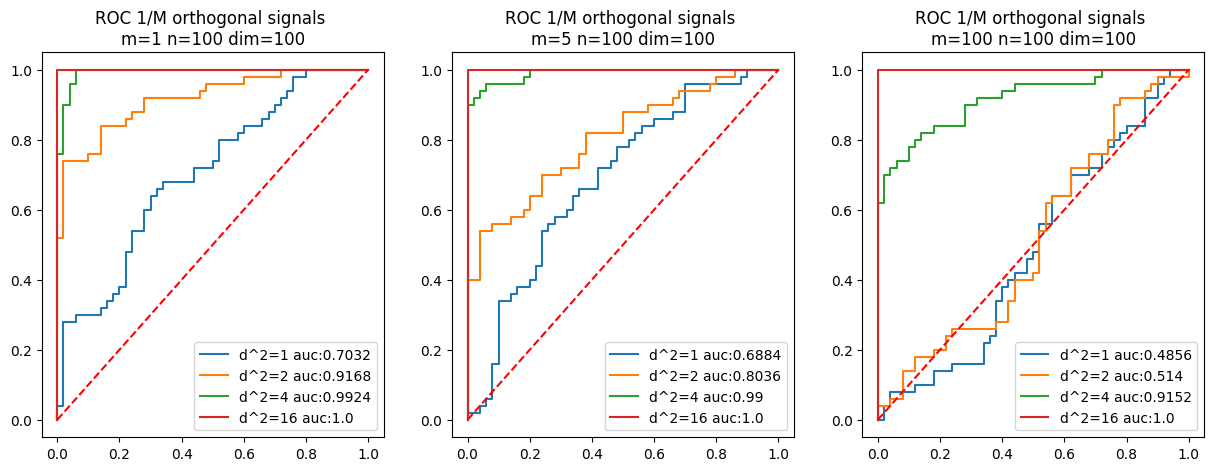

In [66]:
np.random.seed(seed=0)
M = [1,5,100]
d2 = [1,2,4,16]
E = 1
signalDim = 100
n = 100

def filter_1_M(x, noise_variance, m_orthogonal_signals):
    prodSum = E/noise_variance * (x @ m_orthogonal_signals.T)
    # print("prodsum",prodSum)
    exp = np.exp(prodSum)
    # print("exp",exp)
    lambdaa = (1/m) * np.sum(exp, axis=1) 
    # print("lambda",lambdaa)
    return lambdaa
fig, ax = plt.subplots(1,len(M), figsize=(15,5))
for i,m in enumerate(M):
    for d in d2:
        noise_variance = E/d        
        m_orthogonal_signals = generate_orthogonal_signals(m, signalDim)
        rand_m = np.random.choice(m, n//2)
        

        h1 = m_orthogonal_signals[rand_m] + np.random.normal(0, noise_variance, size=(n//2, signalDim))
        h0 = np.random.normal(0, noise_variance, size=(n//2, signalDim))
        decisionStats = np.ndarray((n,2))

        decisionStats[n//2:,0] = filter_1_M(h0, noise_variance, m_orthogonal_signals)
        decisionStats[n//2:,1] = 0
        decisionStats[:n//2,0] = filter_1_M(h1, noise_variance, m_orthogonal_signals)
        decisionStats[:n//2,1] = 1
        
        decisionStats = decisionStats[decisionStats[:, 0].argsort()]
        pd,pfa = calcPdPfa(decisionStats)
        auc = metrics.auc(pfa,pd)
        ax[i].plot(pfa,pd, label=f"d^2={d} auc:{round(auc,5)}") 
        ax[i].legend()
        ax[i].set_title(f"ROC 1/M orthogonal signals \nm={m} n={n} dim={signalDim}")
    ax[i].plot([0, 1], [0, 1],'r--')
plt.show()



# 2) SKEP

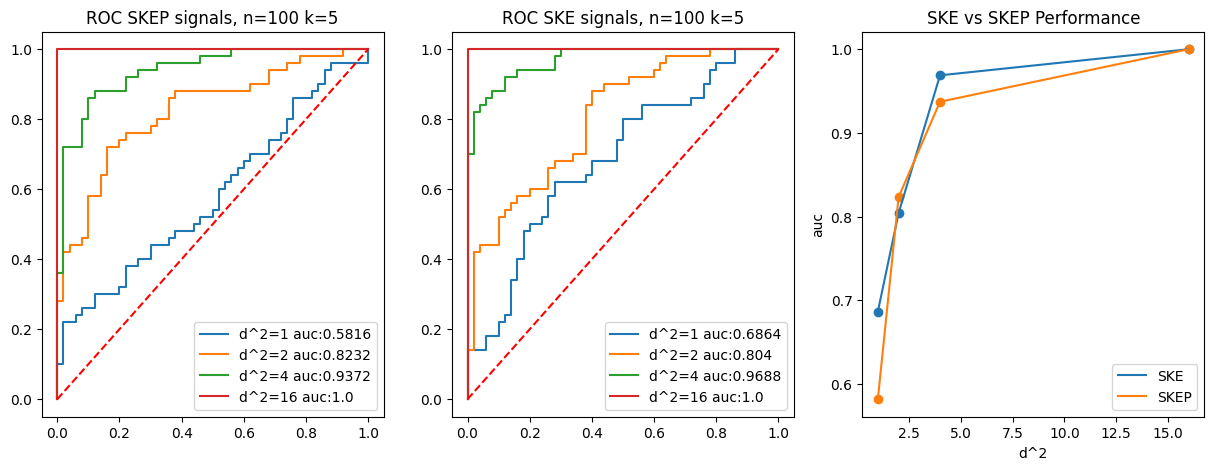

In [61]:
np.random.seed(seed=0)

d2 = [1,2,4,16]
E = 1
amp = 1
freq = 10
k=5
n = 100

unknownPhase = np.random.uniform(0, 2*np.pi)
t = np.linspace(0, 2 * np.pi, k)
signal = amp * np.sin(freq * t + unknownPhase)

fig, ax = plt.subplots(1,3,figsize=(15,5))

SKEP = []
for d in d2:
    noise_variance = E/d

    h1 = signal + np.random.normal(0, noise_variance, size=(n//2, k))
    h0 = np.random.normal(0, noise_variance, size=(n//2, k))
    decisionStats = np.ndarray((n,2))

    decisionStats[:n//2,0] = np.power(np.sum(h1*amp*np.cos(freq * t), axis=1),2) + np.power(np.sum(h1*amp*np.sin(freq * t), axis=1),2)
    decisionStats[:n//2,1] = 1

    decisionStats[n//2:,0] = np.power(np.sum(h0*amp*np.cos(freq * t), axis=1),2) + np.power(np.sum(h0*amp*np.sin(freq * t), axis=1),2)
    decisionStats[n//2:,1] = 0

    decisionStats = decisionStats[decisionStats[:, 0].argsort()]

    pd,pfa = calcPdPfa(decisionStats)
    auc = metrics.auc(pfa,pd)

    ax[0].plot(pfa,pd, label=f"d^2={d} auc:{round(auc,5)}") 
    ax[0].set_title(f"ROC SKEP signals, n={n} k={k}")
    SKEP.append(auc)

SKE = []
for d in d2:
    noise_variance = E/d

    h1 = signal + np.random.normal(0, noise_variance, size=(n//2, k))
    h0 = np.random.normal(0, noise_variance, size=(n//2, k))
    decisionStats = np.ndarray((n,2))

    decisionStats[:n//2,0] = h1 @ signal.T
    decisionStats[:n//2,1] = 1

    decisionStats[n//2:,0] = h0 @ signal.T
    decisionStats[n//2:,1] = 0

    decisionStats = decisionStats[decisionStats[:, 0].argsort()]

    pd,pfa = calcPdPfa(decisionStats)
    auc = metrics.auc(pfa,pd)

    ax[1].plot(pfa,pd, label=f"d^2={d} auc:{round(auc,5)}") 
    ax[1].set_title(f"ROC SKE signals, n={n} k={k}")
    SKE.append(auc)

ax[0].legend()
ax[1].legend()
ax[0].plot([0, 1], [0, 1],'r--')
ax[1].plot([0, 1], [0, 1],'r--')

ax[2].plot(d2, SKE, label="SKE")
ax[2].scatter(d2, SKE)
ax[2].scatter(d2, SKEP)
ax[2].plot(d2, SKEP, label="SKEP")
ax[2].set_xlabel("d^2")
ax[2].set_ylabel("auc")
ax[2].set_title("SKE vs SKEP Performance")
ax[2].legend()
plt.show()


# 3) SKEA

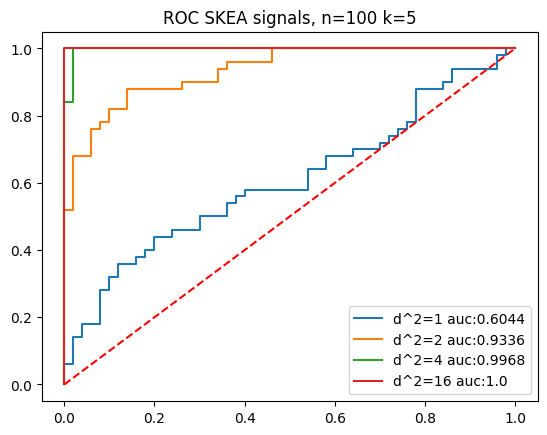

In [67]:
np.random.seed(seed=0)

d2 = [1,2,4,16]
E = 1
freq = 10
n = 100
k=5


unknownAmp = np.random.uniform(0.0,1.0)
phase = np.random.uniform(0, 2*np.pi)
t = np.linspace(0, 2 * np.pi, k)
signal = unknownAmp * np.sin(freq * t + phase) 

fig, ax = plt.subplots()
for d in d2:
    noise_variance = E/d

    h1 = signal + np.random.normal(0, noise_variance, size=(n//2, k))
    h0 = np.random.normal(0, noise_variance, size=(n//2, k))
    decisionStats = np.ndarray((n,2))

    decisionStats[:n//2,0] = np.power(np.trapz(h1*np.sin(freq * t + phase), t, axis=1),2) + np.power(np.trapz(h1*np.cos(freq * t + phase), t, axis=1),2)
    decisionStats[:n//2,1] = 1

    decisionStats[n//2:,0] = np.power(np.trapz(h0*np.sin(freq * t + phase), t, axis=1),2) + np.power(np.trapz(h0*np.cos(freq * t + phase), t, axis=1),2)
    decisionStats[n//2:,1] = 0

    decisionStats = decisionStats[decisionStats[:, 0].argsort()]

    pd,pfa = calcPdPfa(decisionStats)
    auc = metrics.auc(pfa,pd)
    ax.plot(pfa,pd, label=f"d^2={d} auc:{round(auc,5)}") 
    
    
ax.legend()
ax.set_title(f"ROC SKEA signals, n={n} k={k}")
ax.plot([0, 1], [0, 1],'r--')
plt.show()

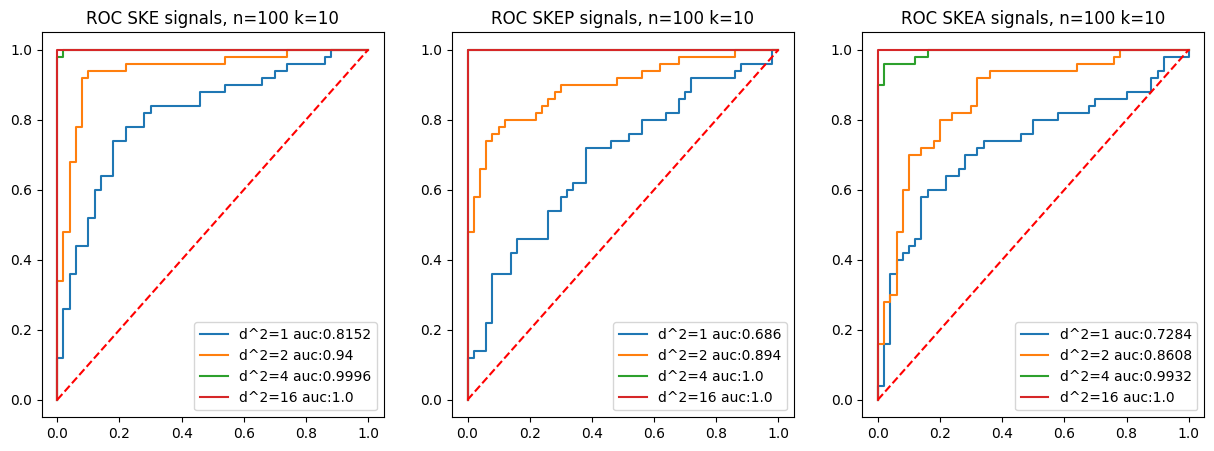

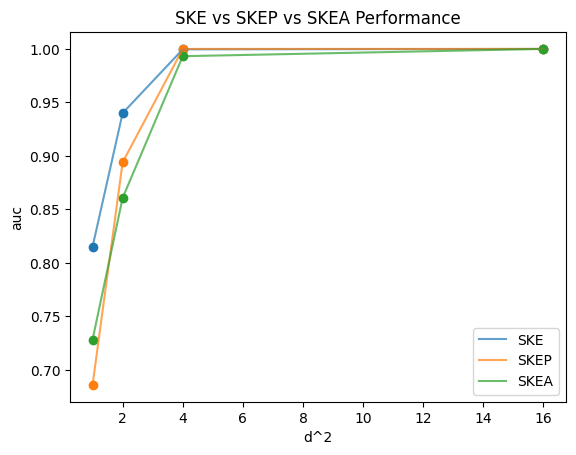

In [83]:
np.random.seed(seed=0)

d2 = [1,2,4,16]
E = 1
freq = 10
n = 100
k=10

amp = np.random.uniform(0.0,1.0)
phase = np.random.uniform(0, 2*np.pi)
t = np.linspace(0, 2 * np.pi, k)
signal = amp * np.sin(freq * t + phase) 

fig, ax = plt.subplots(1,3,figsize=(15,5))

SKE = []
for d in d2:
    noise_variance = E/d

    h1 = signal + np.random.normal(0, noise_variance, size=(n//2, k))
    h0 = np.random.normal(0, noise_variance, size=(n//2, k))
    decisionStats = np.ndarray((n,2))

    decisionStats[:n//2,0] = h1 @ signal.T
    decisionStats[:n//2,1] = 1

    decisionStats[n//2:,0] = h0 @ signal.T
    decisionStats[n//2:,1] = 0

    decisionStats = decisionStats[decisionStats[:, 0].argsort()]

    pd,pfa = calcPdPfa(decisionStats)
    auc = metrics.auc(pfa,pd)

    ax[0].plot(pfa,pd, label=f"d^2={d} auc:{round(auc,5)}") 
    ax[0].set_title(f"ROC SKE signals, n={n} k={k}")
    SKE.append(auc)

SKEP = []
for d in d2:
    noise_variance = E/d

    h1 = signal + np.random.normal(0, noise_variance, size=(n//2, k))
    h0 = np.random.normal(0, noise_variance, size=(n//2, k))
    decisionStats = np.ndarray((n,2))

    decisionStats[:n//2,0] = np.power(np.sum(h1*amp*np.cos(freq * t), axis=1),2) + np.power(np.sum(h1*amp*np.sin(freq * t), axis=1),2)
    decisionStats[:n//2,1] = 1

    decisionStats[n//2:,0] = np.power(np.sum(h0*amp*np.cos(freq * t), axis=1),2) + np.power(np.sum(h0*amp*np.sin(freq * t), axis=1),2)
    decisionStats[n//2:,1] = 0

    decisionStats = decisionStats[decisionStats[:, 0].argsort()]

    pd,pfa = calcPdPfa(decisionStats)
    auc = metrics.auc(pfa,pd)

    ax[1].plot(pfa,pd, label=f"d^2={d} auc:{round(auc,5)}") 
    ax[1].set_title(f"ROC SKEP signals, n={n} k={k}")
    SKEP.append(auc)

SKEA = []
for d in d2:
    noise_variance = E/d

    h1 = signal + np.random.normal(0, noise_variance, size=(n//2, k))
    h0 = np.random.normal(0, noise_variance, size=(n//2, k))
    decisionStats = np.ndarray((n,2))
    decisionStats[:n//2,0] = np.power(np.trapz(h1*np.sin(freq * t + phase), t, axis=1),2) + np.power(np.trapz(h1*np.cos(freq * t + phase), t, axis=1),2)
    decisionStats[:n//2,1] = 1

    decisionStats[n//2:,0] = np.power(np.trapz(h0*np.sin(freq * t + phase), t, axis=1),2) + np.power(np.trapz(h0*np.cos(freq * t + phase), t, axis=1),2)
    decisionStats[n//2:,1] = 0

    decisionStats = decisionStats[decisionStats[:, 0].argsort()]

    pd,pfa = calcPdPfa(decisionStats)
    auc = metrics.auc(pfa,pd)
    ax[2].plot(pfa,pd, label=f"d^2={d} auc:{round(auc,5)}") 
    ax[2].set_title(f"ROC SKEA signals, n={n} k={k}")
    SKEA.append(auc)

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].plot([0, 1], [0, 1],'r--')
ax[1].plot([0, 1], [0, 1],'r--')
ax[2].plot([0, 1], [0, 1],'r--')
plt.show()

fig, ax = plt.subplots()
ax.scatter(d2, SKE)
ax.scatter(d2, SKEP)
ax.scatter(d2, SKEA)
ax.plot(d2, SKE, label="SKE", alpha=0.7)
ax.plot(d2, SKEP, label="SKEP", alpha=0.7)
ax.plot(d2, SKEA, label="SKEA", alpha=0.7)
ax.set_xlabel("d^2")
ax.set_ylabel("auc")
ax.set_title("SKE vs SKEP vs SKEA Performance")
ax.legend()
plt.show()